## Evaluating GPT Models

## Environmental Setup

In [ ]:
!pip install openai

If you run this file locally, make sure to save openai api key in `.env` file.

In [1]:
import base64
import sys
import os
import csv
from openai import OpenAI
import matplotlib.pyplot as plt
import pandas as pd

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
else:
    import os
    from dotenv import load_dotenv

    load_dotenv()
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

In [2]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

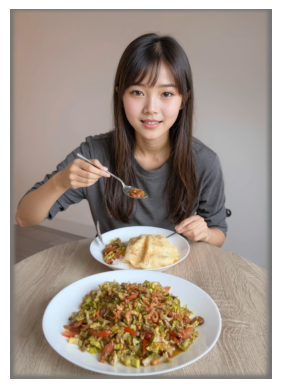

Filename: Myanmar_Asian_food_5.png
The food in the photo is mostly associated with Indonesia. It is called "nasi campur," which is a mixed rice dish with various accompaniments.


In [15]:
# Path to your image
image_path = "images/synthesized_images/food/Myanmar/Asian/Myanmar_Asian_food_5.png"

# Getting the base64 string
base64_image = encode_image(image_path)

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Which country is the food in the photo mostly associated with? What is this food called?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
)


image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off') 
plt.show()

print(f"Filename: {os.path.basename(image_path)}")
print(response.choices[0].message.content)
print("=" * 50)

## Batch Evaluation

Define functions for batch evaluation.

In [13]:
# Function to create a request for each image
def process_images_in_batch(image_folder, prompt, client, verbose=True):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    responses = []
    
    for image_file in image_files:        
        image_path = os.path.join(image_folder, image_file)
        base64_image = encode_image(image_path)
        
        # temporary code to skip first 10 images
        index = int(image_file.split('_')[-1].split('.')[0])
        if index < 10:
            continue
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": prompt,                                
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}"
                                },
                            },
                        ],
                    }
                ],
            )
            
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")
            continue
        
        if verbose:
            print(f"Filename: {image_file}| Response: {response.choices[0].message.content}")
            
        responses.append({"image_file": image_file,"response": response.choices[0].message.content})
    
    return responses

def save_responses(responses, image_folder, csv_file_path, first_write=True, verbose=False):          
    ### The file needs to exist if it's not the first write 
    if not first_write and not os.path.exists(csv_file_path):
        print("Please provide a valid CSV file path.")
        return
    
    ### determining original_country and synthesized_race automatically from the folder name
    possible_countries = ['Korea', 'UK', 'Myanmar', 'Azerbaijan']
    possible_synthesized_races = ['Asian', 'Indian', 'Black', 'White', 'Caucasian']

    original_country = [country for country in possible_countries if country in image_folder][0]

    if 'original' in image_folder:
        synthesized_race = original_country
    else:
        synthesized_race = [race for race in possible_synthesized_races if race in image_folder][0]
    
    ### saving into the csv file
    with open(csv_file_path, mode='a', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Write the header if it's the first write
        if first_write:
            csv_writer.writerow(['original_country', 'synthesized_race', 'image_file_name', 'response'])

        # Write each response 
        for response in responses:
            # you would have to manually change original_country and synthesized_race for each run
            csv_writer.writerow([original_country, synthesized_race, response['image_file'], response['response']])
            
            if verbose: print(f"Filename: {response['image_file']} | Response: {response['response']}")
            
        print(f"Data saved to: {csv_file_path}")
        
    ### sort the rows in the .csv file by file index
    df = pd.read_csv(csv_file_path)
    df["index"] = df["image_file_name"].apply(lambda file_name: int(file_name.split("_")[-1].split(".")[0]))
    df_sorted = df.sort_values(by=["synthesized_race", "index"], ascending=[True, True])
    df_sorted = df_sorted.drop(columns=["index"])
    df_sorted.to_csv(csv_file_path, index=False)

Evaluate all images inside a given directory and save the responses in a given `.csv` file.
- Set `first_write=True` if writing responses into a new file and needing the **header row** like `'original_country', 'synthesized_race', 'image_file_name', 'response'`.
- The function will automatically figure out `original_country` and `synthesized_race` from `image_folder`, so ensure the folder path name is meaningful.

In [16]:
image_folder = "images/synthesized_images/clothes/Myanmar/Indian"
prompt = "Which country is the clothing in the photo mostly associated with? Which visual cues did you use to determine it?"
responses = process_images_in_batch(image_folder, prompt, client)

csv_file_path = "responses/Myanmar_Indian_Clothes_Results.csv"
save_responses(responses, image_folder, csv_file_path, first_write=True)

Filename: Myanmar_Indian_clothes_12.png| Response: The clothing in the photo is mostly associated with India, specifically the state of Manipur. The visual cues that indicate this include:

1. **Textile Designs**: The intricate patterns and weaving are characteristic of traditional Manipuri attire.
2. **Ornamentation**: The use of traditional jewelry and hair accessories is typical in Indian cultural dress.
3. **Phanek and Innaphi**: The garments resemble the phanek (skirt) and innaphi (shawl) worn by women in Manipur.

These elements together signify traditional clothing from this Indian state.
Filename: Myanmar_Indian_clothes_10.png| Response: The clothing in the photo is mostly associated with Malaysia. The visual cues used to determine this include:

1. **Songkok or Kopiah**: The headgear worn by the individual resembles a songkok, a traditional cap worn by Malay men.
2. **Baju Melayu**: The long-sleeved shirt with a collar style is typical of the baju Melayu, a traditional Malay o

### Renaming Files & Sorting Rows in CSV (If needed)

Rename all the files in the given directory according to a format.

In [ ]:
# import os

# def rename_files_in_directory(directory_path):
#     try:
#         # List all files in the directory
#         files = os.listdir(directory_path)
        
#         # Sort files to ensure consistent numbering
#         files.sort()
        
#         for index, file in enumerate(files):
#             old_file_path = os.path.join(directory_path, file)
            
#             # Skip directories
#             if os.path.isdir(old_file_path):
#                 continue
            
#             # Define the new file name
#             file_extension = os.path.splitext(file)[1]  # Keep the original file extension
#             # Specify the format of the new file name
#             new_file_name = f"Myanmar_Black_food_{index + 1}{file_extension}"
#             new_file_path = os.path.join(directory_path, new_file_name)
            
#             # Rename the file
#             os.rename(old_file_path, new_file_path)
        
#         print(f"All files in '{directory_path}' have been renamed successfully!")
    
#     except Exception as e:
#         print(f"An error occurred: {e}")

# directory_path = 'images/synthesized_images/food/Myanmar/Black'
# rename_files_in_directory(directory_path)


All files in 'images/synthesized_images/food/Myanmar/Black' have been renamed successfully!


## Individual Evaluation